# **Applying KAN-PIN to the Marmousi Velocity Model**  

For the Marmousi velocity model, where velocity variations are highly complex, KANs might overfit to noise or spurious correlations. 
By combining Physics Informed Neural Network, we can mitigate this by ensuring that the learned representations align with expected physical behaviors in ray tracing, improving generalization and stability. 
This approach allows KANs to learn meaningful solutions that are both data-efficient and physically valid.

## **Setup**

The following cells configure the environment for the experiment. This includes:
*   **Loading extensions and libraries**: Essential for data manipulation, deep learning, and visualization.
*   **Device configuration**: Sets the computation device to CUDA if available, otherwise defaults to CPU.
*   **Path definitions**: Specifies the paths for data, output, and model checkpoints.

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import random
from itertools import cycle, product
from pathlib import Path
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go
import seaborn as sns

from tqdm.auto import tqdm
from kan import KAN

import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Sampler
from utils.architecture import Architecture
from rt_python import DataGeneratorMarmousi
from utils.metrics import score

SEED = 42

/home/m2ai/miniconda3/envs/exai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Use CUDA device when available. Otherwise, use CPU device.

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using '{DEVICE}' device.")

Using 'cuda' device.


Setup your path to data, output and checkpoint folders. 

In [4]:
DATA_PATH = Path("./data/marmousi")
OUTPUT_PATH = Path("./output/marmousi")
CHECKPOINT_PATH = OUTPUT_PATH/"model"

## **Data Acquisition**

The dataset used in this study is derived from the Marmousi velocity model, a well-known synthetic benchmark in geophysics. This model represents a highly complex subsurface with strong velocity variations, making it ideal for testing ray-tracing algorithms and machine-learning approaches in seismic imaging.

To improve numerical stability and facilitate more efficient training, we normalize the velocity values by converting them to **km/s**. This transformation mitigates scale discrepancies (e.g., values ranging from 10 to 10,000), ensuring better gradient propagation and more stable optimization during model training.

In [10]:
# Model parameters
nx = 2301  # Number of samples in the distance dimension
nz = 751   # Number of samples in the depth dimension
dz = 4     # Distance increment (m)
dx = 4     # Depth increment (m)

# Model limits in km
xmax = nx * dx / 1000
zmax = nz * dz / 1000

vp_file = "data/marmousi_vp.bin"

vp = np.fromfile(vp_file, dtype=np.dtype('float32').newbyteorder('<'))
vp = vp.reshape((nx, nz)).transpose() / 1000  # Converting to km/s
vp.shape

(751, 2301)

Visualizing the Marmousi Velocity Model with Matplotlib

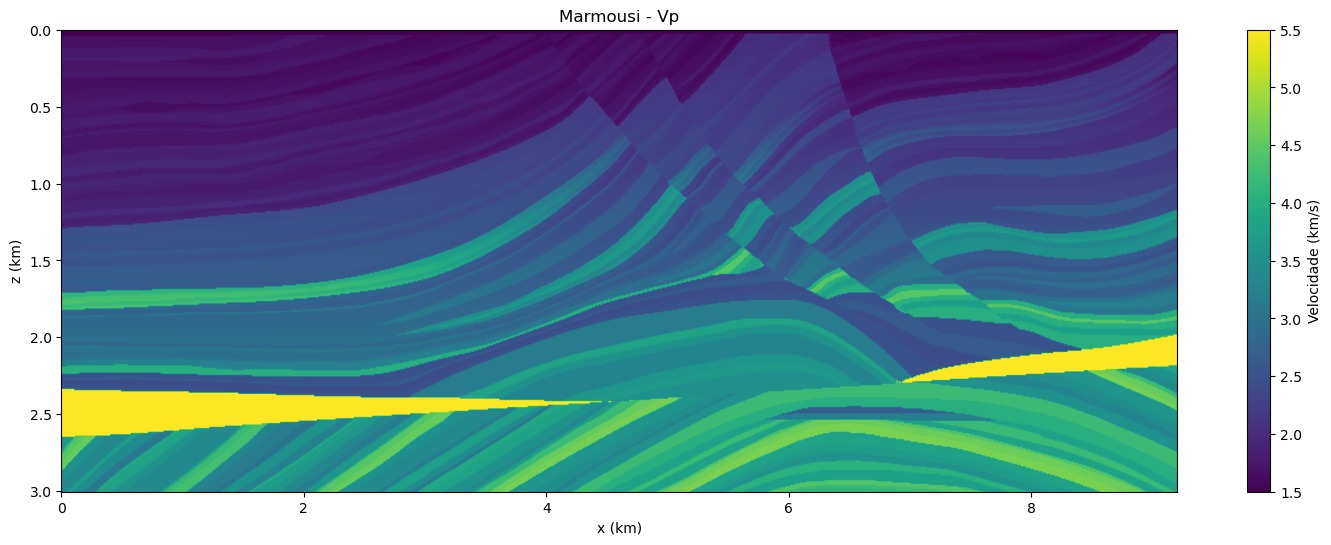

In [ ]:
plt.figure(figsize=(18, 6))
plt.imshow(vp, extent=[0, xmax, zmax, 0], aspect='auto', cmap='viridis')
plt.colorbar(label="Velocity (km/s)")
plt.title("Marmousi - Vp")
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.show()

### **Ray-Tracing Data Generation and Visualization Using `DataGeneratorMarmousi`**

The **`DataGeneratorMarmousi`** class systematically generates ray-tracing data within the **Marmousi velocity model**, enabling machine learning-driven approaches in seismic modeling. By leveraging B-spline interpolation and numerical integration, it constructs high-quality training datasets that capture wave propagation dynamics. The class extends `DataGenerator`, inheriting core spatial attributes without redefining the constructor. Its key method, `run_multiple`, generates ray trajectories across a predefined range of initial positions `(x0, z0)` and angles `(θ0)`, ensuring comprehensive sampling of the velocity model. This process involves interpolating the velocity field for smooth representation, numerically solving ray equations, and aggregating the computed paths into a structured **DataFrame**. The resulting dataset is optimized for training **Kolmogorov-Arnold Networks (KANs)** and other ML models, providing a physics-informed foundation for learning seismic wave behavior while maintaining computational efficiency.  

The code below initializes an instance of `DataGeneratorMarmousi` and generates a dataset of ray-tracing paths within the **Marmousi velocity model**. The process consists of three main steps:  

1. **Defining the Spatial Domain**:  
   The `x_range` and `z_range` parameters define the horizontal and depth extents of the velocity model, ranging from `0` to `xmax` and `0` to `zmax`, respectively. These boundaries ensure that rays are traced within the predefined seismic model.  

2. **Generating Ray-Tracing Data (`run_multiple`)**:  
   The method `run_multiple` is called to compute multiple ray trajectories, systematically sampling different initial conditions:
   - **`x0_range=(4, 6)` and `z0_range=(1, 2)`**: Specifies that rays originate from positions within these spatial bounds.  
   - **`theta_range=(45, 75)`**: Defines the range of initial propagation angles in degrees.  
   - **`vp=vp`**: Passes the Marmousi velocity model as input.  
   - **`factor=30`**: Controls the downsampling of the velocity field for computational efficiency.  
   - **`dx_dy=0.1`**: Sets the resolution for sampling initial positions.  

   The method iterates over all combinations of `(x0, z0, θ0)`, computes the corresponding ray trajectories, and stores the results in a structured **DataFrame** (`df`). This dataset includes the spatial evolution of each ray over time, along with its velocity and direction of propagation.  

3. **Visualization (`plot`)**:  
   The `plot` method visualizes the generated ray paths overlaid on the velocity model. The **velocity field** is represented as a colormap, while the **ray trajectories** illustrate how seismic waves travel through the subsurface. The figure size `(22,6)` ensures clarity, and `plt.show()` displays the plot.  

This workflow effectively generates a diverse dataset for **machine learning applications**, such as training **Kolmogorov-Arnold Networks (KANs)** to learn seismic wave propagation patterns while maintaining physical consistency.


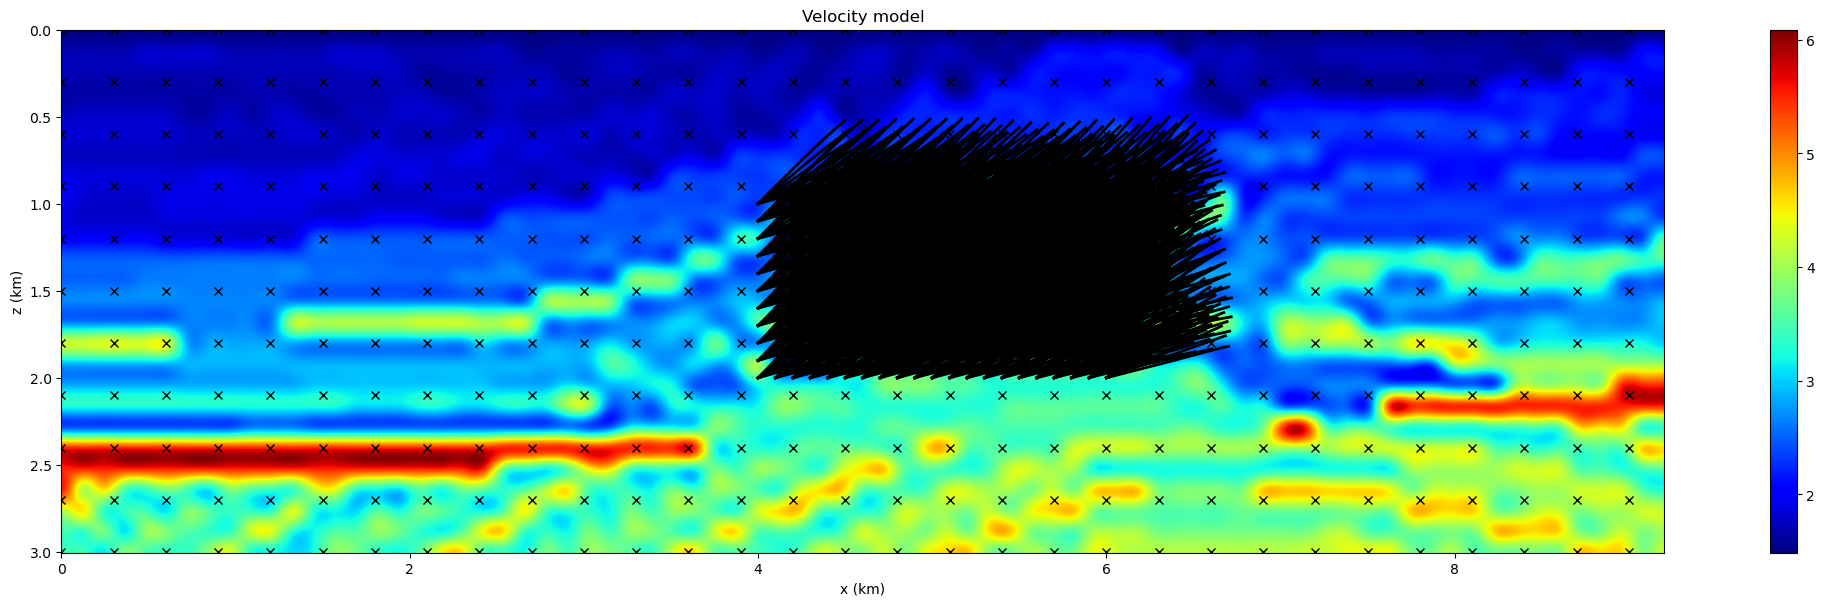

In [29]:
x_range = (0, xmax)
z_range = (0, zmax)

data_gen = DataGeneratorMarmousi(
    x_range=x_range,
    z_range=z_range
)
df = data_gen.run_multiple(x0_range=(4, 6),
                           z0_range=(1, 2),
                           theta_range=(45, 75),
                           vp=vp,
                           factor=30,
                           dx_dy=0.1)
fig = data_gen.plot(df, figsize=(22, 6))
plt.show()

Here, we define the feature groups for our architecture: **KAN features** (inputs to the Kolmogorov-Arnold Network), **Arch features** (KAN features plus additional features used in the PIN module), and **target features** (the predicted output). This organization ensures a clear and structured data flow within the model.

In [9]:
kan_features = ['x0', 'z0', 'theta0_p', 't']
arch_features = kan_features + ['pi_weight', 'dxdt', 'dzdt', 'dpxdt', 'dpzdt']
target = ['x', 'z', 'px', 'pz']

### **Weights in PINN Loss Function**  

In **Physics-Informed Neural Networks (PINNs)**, loss weighting plays a crucial role in balancing data-driven learning with physical constraints. The weights used in the PINN loss function dynamically adjust the contribution of data and physics-based constraints. In regions with dense data points, the model prioritizes data fidelity, while in sparsely sampled areas, it emphasizes adherence to the governing equations. This adaptive weighting ensures a balanced learning process, improving generalization across the entire domain.  

Here, the **weighting strategy is based on spatial frequency**. The code computes the number of data points within predefined spatial regions (squares), assigning higher weights to underrepresented areas and lower weights to densely populated regions. This **adaptive weighting** prevents the model from overfitting high-density regions and helps it generalize across the entire domain.  

By incorporating these weights into the PINN loss function, the model effectively learns from both observed data and physics-based constraints, leading to improved stability, accuracy, and robustness in solving inverse problems in seismic modeling.

In [5]:
def get_squares_limits(data: pd.DataFrame, restrictions: dict, step: float) -> np.ndarray:
    """
    Generates a set of square limits based on specified feature restrictions and step size.

    This function partitions the feature space into discrete intervals based on given restrictions,
    creating a grid of square regions for further analysis.

    Args:
        data (pd.DataFrame): The input dataset containing feature columns.
        restrictions (dict): A dictionary defining the range of each feature. 
            Each key corresponds to a feature name, and its value is a dictionary 
            with 'min' and 'max' keys specifying the range.
        step (float): The step size used to discretize the feature space.

    Returns:
        np.ndarray: A NumPy array containing all possible square intervals formed by the 
        specified feature restrictions.
    
    Raises:
        AssertionError: If any feature in `restrictions` is not present in the dataset.

    Example:
        >>> data = pd.DataFrame({'x': [1, 2, 3], 'y': [4, 5, 6]})
        >>> restrictions = {'x': {'min': 0, 'max': 3}, 'y': {'min': 4, 'max': 6}}
        >>> get_squares_limits(data, restrictions, step=1)
        array([[[0., 1.], [4., 5.]],
               [[0., 1.], [5., 6.]],
               [[1., 2.], [4., 5.]],
               [[1., 2.], [5., 6.]],
               [[2., 3.], [4., 5.]],
               [[2., 3.], [5., 6.]]], dtype=float32)
    """
    assert all([feature in data.columns for feature in restrictions.keys()]), \
        "Some features presented in restrictions are not in the data."

    # Generate the intervals for each feature
    limits_map = {}
    for name, boundary in restrictions.items():
        aux = np.arange(boundary['min'], boundary['max'] + step, step=step, dtype='float32')
        aux = [round(x, 3) for x in aux]
        limits_map[name] = [(aux[i], aux[i+1]) for i in range(len(aux) - 1)]

    # Create all combinations of the intervals between features
    combinations = list(product(*limits_map.values()))

    result = [np.array(combination, dtype='float32') for combination in combinations]

    return np.array(result, dtype='float32')

In [6]:
def get_frequency(data: pd.DataFrame, restrictions: dict, step: float = 0.1) -> pd.DataFrame:
    """
    Computes the frequency of data points within predefined square regions in the feature space.

    This function divides the input data into grid-based square regions and counts the number 
    of data points falling within each region. The result is stored in a DataFrame.

    Args:
        data (pd.DataFrame): The dataset containing the features to be analyzed.
        restrictions (dict): A dictionary defining feature-wise range restrictions.
            Each key corresponds to a feature name, with 'min' and 'max' specifying the range.
        step (float, optional): The step size used to define square regions. Default is 0.1.

    Returns:
        pd.DataFrame: A DataFrame containing each square's limits and the corresponding data point count.

    Example:
        >>> data = pd.DataFrame({'x': [0.5, 1.5, 2.5], 'y': [4.5, 5.5, 6.5]})
        >>> restrictions = {'x': {'min': 0, 'max': 3}, 'y': {'min': 4, 'max': 6}}
        >>> get_frequency(data, restrictions, step=1)
           square   frequency
        0  [[0, 1], [4, 5]]  1
        1  [[0, 1], [5, 6]]  0
        2  [[1, 2], [4, 5]]  0
        3  [[1, 2], [5, 6]]  1
        4  [[2, 3], [4, 5]]  0
        5  [[2, 3], [5, 6]]  1
    """
    squares_limits = get_squares_limits(data, restrictions, step)

    # Count points in each square
    frequencies = []
    for square in squares_limits:
        mask = np.ones(len(data), dtype=bool)
        for feature, limits in zip(restrictions.keys(), square):
            sqr_min, sqr_max = limits
            mask &= (data[feature] >= sqr_min) & (data[feature] < sqr_max)

        # Count points inside this square
        frequencies.append(np.sum(mask))

    # Prepare result as a DataFrame
    frequency_df = pd.DataFrame(
        data={
            "square": list(squares_limits),
            "frequency": frequencies
        }
    )

    return frequency_df


In [7]:
def add_frequency_to_data(data: pd.DataFrame, frequency_df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds frequency information to the dataset based on predefined spatial regions.

    This function assigns a frequency value to each data point by matching it to the 
    corresponding region (square) defined in `frequency_df`. The frequency represents 
    the number of data points found in that region, ensuring that each sample is 
    weighted accordingly for further processing.

    Args:
        data (pd.DataFrame): The input dataset containing feature columns.
        frequency_df (pd.DataFrame): A DataFrame with frequency counts for different 
            spatial regions, where each row contains:
            - "square": A list of tuples defining the boundaries of the region.
            - "frequency": The number of data points within that region.

    Returns:
        pd.DataFrame: A copy of `data` with an added "frequency" column.

    Example:
        >>> data = pd.DataFrame({'x': [0.5, 1.5, 2.5], 'y': [4.5, 5.5, 6.5]})
        >>> frequency_df = pd.DataFrame({
        ...     "square": [[(0,1), (4,5)], [(1,2), (5,6)], [(2,3), (6,7)]],
        ...     "frequency": [10, 5, 3]
        ... })
        >>> add_frequency_to_data(data, frequency_df)
             x    y  frequency
        0  0.5  4.5        10
        1  1.5  5.5         5
        2  2.5  6.5         3
    """
    # Initialize an array to store frequency values
    frequencies = np.zeros(len(data), dtype=int)

    # Iterate over each row in the frequency DataFrame to assign frequencies
    for _, square_row in frequency_df.iterrows():
        square = square_row['square']
        frequency = square_row['frequency']

        # Build a mask to filter the rows in `data` that fall within the current square
        mask = np.ones(len(data), dtype=bool)
        for feature, (min_val, max_val) in zip(data.columns, square):
            mask &= (data[feature] >= min_val) & (data[feature] < max_val)

        # Assign the frequency value to the matching rows
        frequencies[mask] = frequency

    # Create a copy of the dataset and add the frequency column
    data_with_frequency = data.copy()
    data_with_frequency['frequency'] = frequencies

    return data_with_frequency


In [8]:
def plot_surface(data: pd.DataFrame, filename: str = "output/surface_plot.html") -> None:
    """
    Generates a 3D surface plot of point frequencies within spatial regions.

    This function visualizes the frequency distribution of data points across 
    predefined grid regions. It extracts midpoints of the spatial squares and 
    maps the corresponding frequencies, creating a structured 3D surface plot 
    using Plotly.

    Args:
        data (pd.DataFrame): A DataFrame containing:
            - "square": A list of tuples defining the spatial region boundaries.
            - "frequency": The count of data points within each square.
        filename (str, optional): The output file path to save the interactive 
            HTML plot. Default is `"output/surface_plot.html"`.

    Returns:
        None: The function generates and saves the plot but does not return a value.

    Example:
        >>> data = pd.DataFrame({
        ...     "square": [[(0,1), (4,5)], [(1,2), (5,6)], [(2,3), (6,7)]],
        ...     "frequency": [10, 5, 3]
        ... })
        >>> plot_surface(data, filename="surface_plot.html")
    """
    # Extract midpoints and corresponding frequencies
    squares = data['square'].tolist()  # Assuming 'square' column stores lists
    frequencies = data['frequency'].values

    # Compute midpoints for visualization
    x = np.array([(interval[0][0] + interval[0][1]) / 2 for interval in squares])
    y = np.array([(interval[1][0] + interval[1][1]) / 2 for interval in squares])
    z = frequencies

    # Create a structured grid for the surface plot
    unique_x = np.unique(x)
    unique_y = np.unique(y)
    X, Z = np.meshgrid(unique_x, unique_y)

    # Map frequency values to the grid
    freq = np.zeros_like(X)
    for i, x_val in enumerate(unique_x):
        for j, y_val in enumerate(unique_y):
            mask = (x == x_val) & (y == y_val)
            if np.any(mask):
                freq[j, i] = z[mask][0]  # Assign the frequency to the grid point

    # Create 3D surface plot
    fig = go.Figure()
    fig.add_trace(go.Surface(z=freq, x=X, y=Z, opacity=0.8))

    # Customize layout
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Z',
            zaxis_title='Frequency'
        ),
        title='Surface Plot of Points in Squares'
    )

    # Save plot as an interactive HTML file
    fig.write_html(filename)


### **Splitting the Dataset into Training, Validation, and Test Sets**  

Proper dataset partitioning is essential to ensure robust model evaluation and generalization. Here, we divide the data into **training, validation, and test sets**, ensuring that the model learns effectively while being evaluated on unseen data. The **training set** is used to optimize model parameters, the **validation set** helps fine-tune hyperparameters and prevent overfitting, and the **test set** provides an unbiased estimate of final model performance.  


In [34]:
initial_conditions = df[['x0', 'z0', 'theta0_p']].drop_duplicates()
aux = initial_conditions.copy()

ic_train = aux.sample(frac=0.6, random_state=SEED)
ic_val = aux.drop(ic_train.index).sample(frac=0.5, random_state=SEED)
ic_test = aux.drop(list(ic_train.index) + list(ic_val.index))

print("Train Initial Conditions:", len(ic_train))
print("Validation Initial Conditions:", len(ic_val))
print("Test Initial Conditions:", len(ic_test))

Train Initial Conditions: 970
Validation Initial Conditions: 324
Test Initial Conditions: 323


A total of **401 points** are used to construct the ray trajectory, covering a time range from **0 to 400 ms** with a time step (**dt**) of **1 ms**. This high-resolution sampling ensures precise tracking of wave propagation dynamics, improving the accuracy of trajectory estimation.  

In [35]:
df_train = df.merge(ic_train, on=['x0', 'z0', 'theta0_p'], how='inner')
df_val = df.merge(ic_val, on=['x0', 'z0', 'theta0_p'], how='inner')
df_test = df.merge(ic_test, on=['x0', 'z0', 'theta0_p'], how='inner')

print("Train Size:", len(df_train))
print("Validation Size:", len(df_val))
print("Test Size:", len(df_test))

Train Size: 388970
Validation Size: 129924
Test Size: 129523


### Saving the Datasets

The following cell saves the training, validation, and test sets to CSV files. This allows for easy reuse of the same data splits in future experiments without needing to regenerate them.

In [ ]:
df_train.to_csv(DATA_PATH/'train_marmousi_f30.csv', index=False)
df_val.to_csv(DATA_PATH/'val_marmousi_f30.csv', index=False)
df_test.to_csv(DATA_PATH/'test_marmousi_f30.csv', index=False)

### Reading the Datasets

This cell loads the training, validation, and test datasets from the CSV files created in the previous step.

In [ ]:
df_train = pd.read_csv(DATA_PATH/'train_marmousi_f30.csv')
df_val = pd.read_csv(DATA_PATH/'val_marmousi_f30.csv')
df_test = pd.read_csv(DATA_PATH/'test_marmousi_f30.csv')

### Plotting the Frequencies

This section calculates and visualizes the frequency of data points across the spatial domain of the training set. This helps in understanding the data distribution, which is crucial for the subsequent weighting strategy in the PINN loss function. A 3D surface plot is generated to show regions with high and low data density.

In [11]:
restrictions = {
    'x': {'min': 0, 'max': xmax},
    'z': {'min': 0, 'max': zmax},
}
frequency_df = get_frequency(df_train, restrictions)

In [ ]:
plot_surface(frequency_df, filename=DATA_PATH/"frequency_plot_marmousi_f30.html")

In [12]:
df_train_freq = add_frequency_to_data(df_train, frequency_df)
df_train_freq['normalized_frequency'] = (
    (df_train_freq['frequency'] - df_train_freq['frequency'].min()) / (df_train_freq['frequency'].max() - df_train_freq['frequency'].min()))
df_train_freq['pi_weight'] = 1 / df_train_freq['normalized_frequency']
df_train_freq['pi_weight'] = df_train_freq['pi_weight'].clip(0, 10)
df_train_freq.head()

,x,z,px,pz,x0,z0,theta0_p,t,dxdt,dzdt,dpxdt,dpzdt,frequency,normalized_frequency,pi_weight
0,4.000000,1.000000,0.419427,-0.419427,4.0,1.0,2.356194,0.000,1.192103,-1.192103,-0.090877,0.068835,211,0.096641,10.000000
1,4.001192,0.998808,0.419337,-0.419359,4.0,1.0,2.356194,0.001,1.192073,-1.192135,-0.090034,0.068111,346,0.158767,6.298551
2,4.002385,0.997615,0.419248,-0.419292,4.0,1.0,2.356194,0.002,1.192267,-1.192391,-0.088348,0.066658,346,0.158767,6.298551
3,4.003577,0.996423,0.419162,-0.419227,4.0,1.0,2.356194,0.003,1.192457,-1.192642,-0.086660,0.065201,346,0.158767,6.298551
4,4.004770,0.995230,0.419077,-0.419163,4.0,1.0,2.356194,0.004,1.192643,-1.192888,-0.084970,0.063741,346,0.158767,6.298551


In [13]:
df_train_freq.describe()

,x,z,px,pz,x0,z0,theta0_p,t,dxdt,dzdt,dpxdt,dpzdt,frequency,normalized_frequency,pi_weight
count,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000
mean,5.271515,1.323111,0.477923,-0.294167,4.973814,1.501443,2.089627,0.200000,1.471482,-0.901132,-0.015478,-0.089954,1374.101735,0.631892,2.012499
std,0.632407,0.335699,0.055742,0.091029,0.607713,0.318919,0.174940,0.115759,0.187562,0.269246,0.130958,0.177679,474.560367,0.218389,1.534799
min,4.000000,0.495164,0.283296,-0.523838,4.000000,1.000000,1.832596,0.000000,0.810724,-1.525315,-0.316535,-0.492823,1.000000,0.000000,1.000000
25%,4.741374,1.049262,0.436892,-0.371676,4.400000,1.200000,1.919862,0.100000,1.326253,-1.124268,-0.107400,-0.218982,1058.000000,0.486424,1.246701
50%,5.253532,1.329025,0.483738,-0.296906,5.000000,1.500000,2.094395,0.200000,1.489745,-0.913209,-0.016891,-0.095854,1515.000000,0.696733,1.435271
75%,5.798354,1.592272,0.522473,-0.220513,5.500000,1.800000,2.268928,0.300000,1.622252,-0.687031,0.072662,0.048044,1744.000000,0.802117,2.055818
max,6.718274,2.000000,0.594305,-0.067584,6.000000,2.000000,2.356194,0.400000,1.880203,-0.216367,0.325629,0.282259,2174.000000,1.000000,10.000000


In [ ]:
fig = go.Figure(data=[go.Scatter3d(
    x=df_train_freq['x'],
    y=df_train_freq['z'],
    z=df_train_freq['pi_weight'],
    mode='markers',
    marker=dict(
        size=5,
        color=df_train_freq['pi_weight'],  # Color by pi_weight
        colorscale='Viridis',
        opacity=0.8
    )
)])

# Add labels
fig.update_layout(
    scene=dict(
        xaxis_title='x',
        yaxis_title='z',
        zaxis_title='pi_weight'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.write_html(DATA_PATH/"train_pi_weight_plot_marmousi_f30.html")

### DataLoaders Creation

To efficiently manage the data during training, validation, and testing, we create `DataLoaders` for each dataset. This allows for batching, shuffling, and parallel data loading.

#### Sampler Definition

In [ ]:
class BalancedBatchSampler(Sampler):
    def __init__(self, dataset, batch_size, t_index=3, shuffle=True):
        """
    A sampler that generates balanced batches from a dataset, ensuring that each batch contains
    an equal number of samples with a specific target value.
    Args:
        dataset (Dataset): The dataset to sample from.
        batch_size (int): The number of samples per batch.
        t_index (int, optional): The index of the target value in the dataset samples. Default is 4.
        shuffle (bool, optional): Whether to shuffle the batch indices. Default is True.
        
    Attributes:
        dataset (Dataset): The dataset to sample from.
        batch_size (int): The number of samples per batch.
        t_index (int): The index of the target value in the dataset samples.
        shuffle (bool): Whether to shuffle the batch indices.
        t_zero_indices (list): Indices of samples with target value equal to 0.
        non_t_zero_indices (list): Indices of samples with target value not equal to 0.
        
    Methods:
        __iter__(): Generates balanced batches of indices.
        __len__(): Returns the number of batches.
    """
        if batch_size % 2 != 0 or batch_size <= 0:
            raise ValueError("batch_size must be a positive and even integer.")
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.t_index = t_index
        self.shuffle = shuffle

        # Split the dataset into two parts: with t=0 and without t=0
        self.t_zero_indices = []
        self.non_t_zero_indices = []

        for i in range(len(self.dataset)):
            data = self.dataset[i]
            try:
                t_sample = data[0][self.t_index]
            except (IndexError, TypeError):
                raise ValueError(f"The time index t_index={self.t_index} is not valid.")
            if t_sample == 0:
                self.t_zero_indices.append(i)
            else:
                self.non_t_zero_indices.append(i)

        if not self.t_zero_indices or not self.non_t_zero_indices:
            raise ValueError("There are not enough samples in each class to create balanced batches.")

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.t_zero_indices)
            random.shuffle(self.non_t_zero_indices)

        t_zero_iter = cycle(self.t_zero_indices)
        non_t_zero_iter = cycle(self.non_t_zero_indices)

        num_batches = len(self.dataset) // self.batch_size

        for _ in range(num_batches):
            t_zero_batch = [next(t_zero_iter) for _ in range(2)] # Samples with t=0 per batch
            non_t_zero_batch = [next(non_t_zero_iter) for _ in range(self.batch_size-2)]
            batch_indices = t_zero_batch + non_t_zero_batch

            if self.shuffle:
                random.shuffle(batch_indices)

            yield batch_indices

    def __len__(self):
        return len(self.dataset) // self.batch_size


#### Separating Dependent and Independent Variables

In [ ]:
# Converting data to tensors
X_train = torch.as_tensor(df_train_freq[arch_features].values, dtype=torch.float32)
y_train = torch.as_tensor(df_train_freq[target].values, dtype=torch.float32)

X_val = torch.as_tensor(df_val[kan_features].values, dtype=torch.float32)
y_val = torch.as_tensor(df_val[target].values, dtype=torch.float32)

X_test = torch.as_tensor(df_test[kan_features].values, dtype=torch.float32)
y_test = torch.as_tensor(df_test[target].values, dtype=torch.float32)

# Creating the Dataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Creating a loader for each dataset
sampler = BalancedBatchSampler(train_dataset, batch_size=256)
train_loader = DataLoader(dataset=train_dataset,
                          batch_sampler=sampler
                          )

val_loader = DataLoader(dataset=val_dataset,
                        shuffle=False,
                        batch_size=256
                        )

test_loader = DataLoader(dataset=test_dataset,
                        shuffle=False,
                        batch_size=len(test_dataset)
                        )

## Definition of the Physics Cost Function

The `physics_loss_fn` function defines the physics-informed component of the loss. It computes the gradients of the model's outputs with respect to time and enforces the ray tracing equations. This loss component ensures that the model's predictions are physically consistent. It also includes a term to enforce initial conditions, ensuring that at time `t=0`, the ray position matches the initial position `(x0, z0)`.

In [ ]:
# Adjusted physics loss function
def physics_loss_fn(model, input_tensor, *args, **kwargs):
    # Separate the inputs and ensure that the variables require gradient
    x0 = input_tensor[:, 0].view(-1, 1)  # x0
    z0 = input_tensor[:, 1].view(-1, 1)  # z0
    theta0 = input_tensor[:, 2].view(-1, 1)  # theta0
    t_var = input_tensor[:, 3].view(-1, 1)  # t
    
    # Weights for each sample
    weights = input_tensor[:, 4].view(-1, 1)
    
    # Getting the derivatives from the non-parametric model
    dxdt_true = input_tensor[:, 5].view(-1, 1)
    dzdt_true = input_tensor[:, 6].view(-1, 1)
    dpxdt_true = input_tensor[:, 7].view(-1, 1)
    dpzdt_true = input_tensor[:, 8].view(-1, 1)

    # Make sure all variables have requires_grad=True to calculate derivatives
    t_var.requires_grad_(True)

    # Recalculate yhat using the variables to ensure the connection
    x_reconstructed = torch.cat([x0, z0, theta0, t_var], dim=1)
    yhat = model(x_reconstructed)
    
    x_out = yhat[:, 0].view(-1, 1)
    z_out = yhat[:, 1].view(-1, 1)
    px_out = yhat[:, 2].view(-1, 1)
    pz_out = yhat[:, 3].view(-1, 1)
    
    # If t exists in the input tensor
    t_zero_mask = (t_var == 0).squeeze()
    if t_zero_mask.any():
        x0_t0 = x0[t_zero_mask]
        z0_t0 = z0[t_zero_mask]
        
        # Ensure that in t = 0, x = x0 and z = z0
        x_initial_condition = (yhat[t_zero_mask, 0] - x0_t0) ** 2
        z_initial_condition = (yhat[t_zero_mask, 1] - z0_t0) ** 2
        initial_condition_loss = torch.mean(x_initial_condition + z_initial_condition)
    else:
        # If t=0 is not present, loss = 0
        initial_condition_loss = 0
    

    # Calculate the necessary gradients
    dxdt = torch.autograd.grad(
        outputs=x_out,  # Derivative of x with respect to t
        inputs=t_var,
        grad_outputs=torch.ones_like(x_out),
        create_graph=True,
        retain_graph=True
    )[0]

    dzdt = torch.autograd.grad(
        outputs=z_out,  # Derivative of z with respect to t
        inputs=t_var,
        grad_outputs=torch.ones_like(z_out),
        create_graph=True,
        retain_graph=True
    )[0]

    dpxdt = torch.autograd.grad(
        outputs=px_out,  # Derivative of px with respect to t
        inputs=t_var,
        grad_outputs=torch.ones_like(px_out),
        create_graph=True,
        retain_graph=True
    )[0]

    dpzdt = torch.autograd.grad(
        outputs=pz_out,  # Derivative of pz with respect to t
        inputs=t_var,
        grad_outputs=torch.ones_like(pz_out),
        create_graph=True,
        retain_graph=True
    )[0]

    # Differential equations according to your figure
    pde1 = dxdt - dxdt_true
    pde2 = dzdt - dzdt_true
    pde3 = dpxdt - dpxdt_true
    pde4 = dpzdt - dpzdt_true

    # Calculate the loss as the sum of the squared errors of the PDEs
    loss = torch.mean(weights * (pde1 ** 2 + pde2 ** 2 + pde3 ** 2 + pde4 ** 2))
    return loss + initial_condition_loss

## Train and Evaluate Models

This section sets up and executes the model training and evaluation loop. We define the KAN model, an optimizer, and the loss functions. The `Architecture` class wraps these components and handles the training process. The model is trained iteratively with increasing grid sizes for the KAN layers, a technique known as grid refinement. After each training phase, the model is evaluated on the test set, and the results and model checkpoints are saved.

In [10]:
torch.manual_seed(42)

input_size = len(kan_features)
output_size = len(target)
grid_size = [4, 8, 12, 16, 20]

In [ ]:
model = KAN(width=[input_size, 12, 6, output_size],
            grid=grid_size[0],
            grid_range=[0, 10],
            k=3,
            auto_save=False,
            ckpt_path=str(CHECKPOINT_PATH),
            seed=SEED,
            device=DEVICE)

# Defines optimizer to update the parameters
optimizer_type = optim.Adam
optimizer_params = {'lr': 1e-3}


# Defines a MSE loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

In [58]:
arch = Architecture(model,
                    loss_fn,
                    physics_loss_fn,
                    optimizer_type,
                    optimizer_params=optimizer_params,
                    use_weighted_pi=True, 
                    lamb=1e-3,
                    lamb_l1=1e-3,
                    lamb_entropy=2,
                    lamb_coef=0,
                    lamb_coefdiff=0,
                    lambda_physics=1e-3)

arch.set_loaders(train_loader, val_loader)

In [ ]:
save_steps = 25
n_epochs = save_steps * len(grid_size)
evaluation = {}

for i, batch in enumerate(range(int(n_epochs / save_steps))):
    
    new_grid = grid_size[i]
    if i > 0:
        print(f"New grid: {new_grid}")
        arch.refine(new_grid)
    
    # Train model
    arch.train(n_epochs=save_steps, seed=SEED)
    
    # Evaluate each model and store its results in the evaluation dict
    predictions = arch.predict(df_test[kan_features].values)
    df_pred = pd.DataFrame(predictions, columns=target)
    evaluation[new_grid] = score(df_pred[target].values, df_test[target].values)
    evaluation[new_grid].to_csv(str(CHECKPOINT_PATH/f"grid{new_grid}/evaluation.csv"))
    
    # Save each trained model
    save_checkpoint = CHECKPOINT_PATH/f"grid{new_grid}/checkpoint_{arch.total_epochs}.pt"
    os.makedirs(save_checkpoint.parent, exist_ok=True)
    arch.save_checkpoint(save_checkpoint)

Training PIKAN:   0%|          | 0/25 [00:00<?, ?it/s]

[WARNING] Input features are different from the model's input features. Only the first 4 features will be used as model input.


Training PIKAN: 100%|██████████| 25/25 [1:11:03<00:00, 170.54s/it, data_loss=0.000873, loss=0.00442, physics_loss=0.000804, val_loss=0.000872]


New grid: 8


Training PIKAN: 100%|██████████| 50/50 [1:14:29<00:00, 178.76s/it, data_loss=0.000912, loss=0.0039, physics_loss=0.000811, val_loss=0.000967] 


New grid: 12
saving model version 0.2


Training PIKAN: 100%|██████████| 75/75 [1:14:35<00:00, 179.03s/it, data_loss=0.000643, loss=0.0033, physics_loss=0.000588, val_loss=0.000594] 


New grid: 16
saving model version 0.3


Training PIKAN: 100%|██████████| 100/100 [1:09:25<00:00, 166.62s/it, data_loss=0.000642, loss=0.00335, physics_loss=0.000629, val_loss=0.000942]


New grid: 20
saving model version 0.4


Training PIKAN: 100%|██████████| 125/125 [1:09:08<00:00, 165.94s/it, data_loss=0.000666, loss=0.00326, physics_loss=0.000623, val_loss=0.000654]


/tmp/ipykernel_427420/4065197815.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


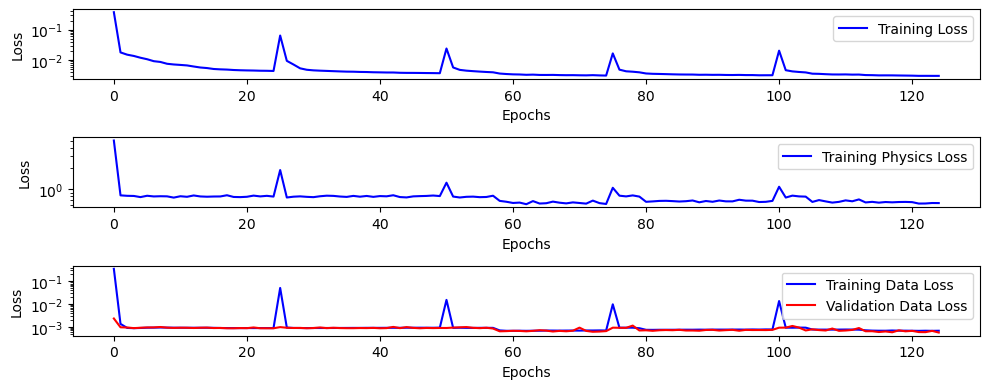

In [ ]:
fig = arch.plot_losses()
fig.show()

## Evaluation

After training, this section is dedicated to a comprehensive evaluation of the models. The performance is analyzed by loading the saved evaluation metrics, transforming the data for easier plotting, and visualizing the results to compare the performance across different grid sizes.

### Transform Evaluation Data

In [11]:
results = {}
for grid in grid_size:
    results[grid] = pd.read_csv(str(CHECKPOINT_PATH/f"grid{grid}/evaluation.csv"), index_col=0)

In [39]:
records = [
    {
        "grid_size": grid_size,
        "metric": metric,
        "target": target,
        "value": df.loc[metric, target]
    }
    for grid_size, df in results.items()
    for metric in df.index
    for target in df.columns
]

df_long = pd.DataFrame.from_records(records)

mean_values = df_long.groupby(["metric", "grid_size"])["value"].mean().reset_index()
mean_values["target"] = "Overall"

df_long = pd.concat([df_long, mean_values], axis=0)
df_long.sort_values(by=["metric", "grid_size"], ascending=True, inplace=True)
df_long.to_csv(str(CHECKPOINT_PATH/"overall_evaluation.csv"), index=False)

### Plot charts

In [5]:
# Read data
df_long = pd.read_csv(str(CHECKPOINT_PATH/"overall_evaluation.csv"))

/tmp/ipykernel_73821/3365711827.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks, fontsize=16)
/tmp/ipykernel_73821/3365711827.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks, fontsize=16)


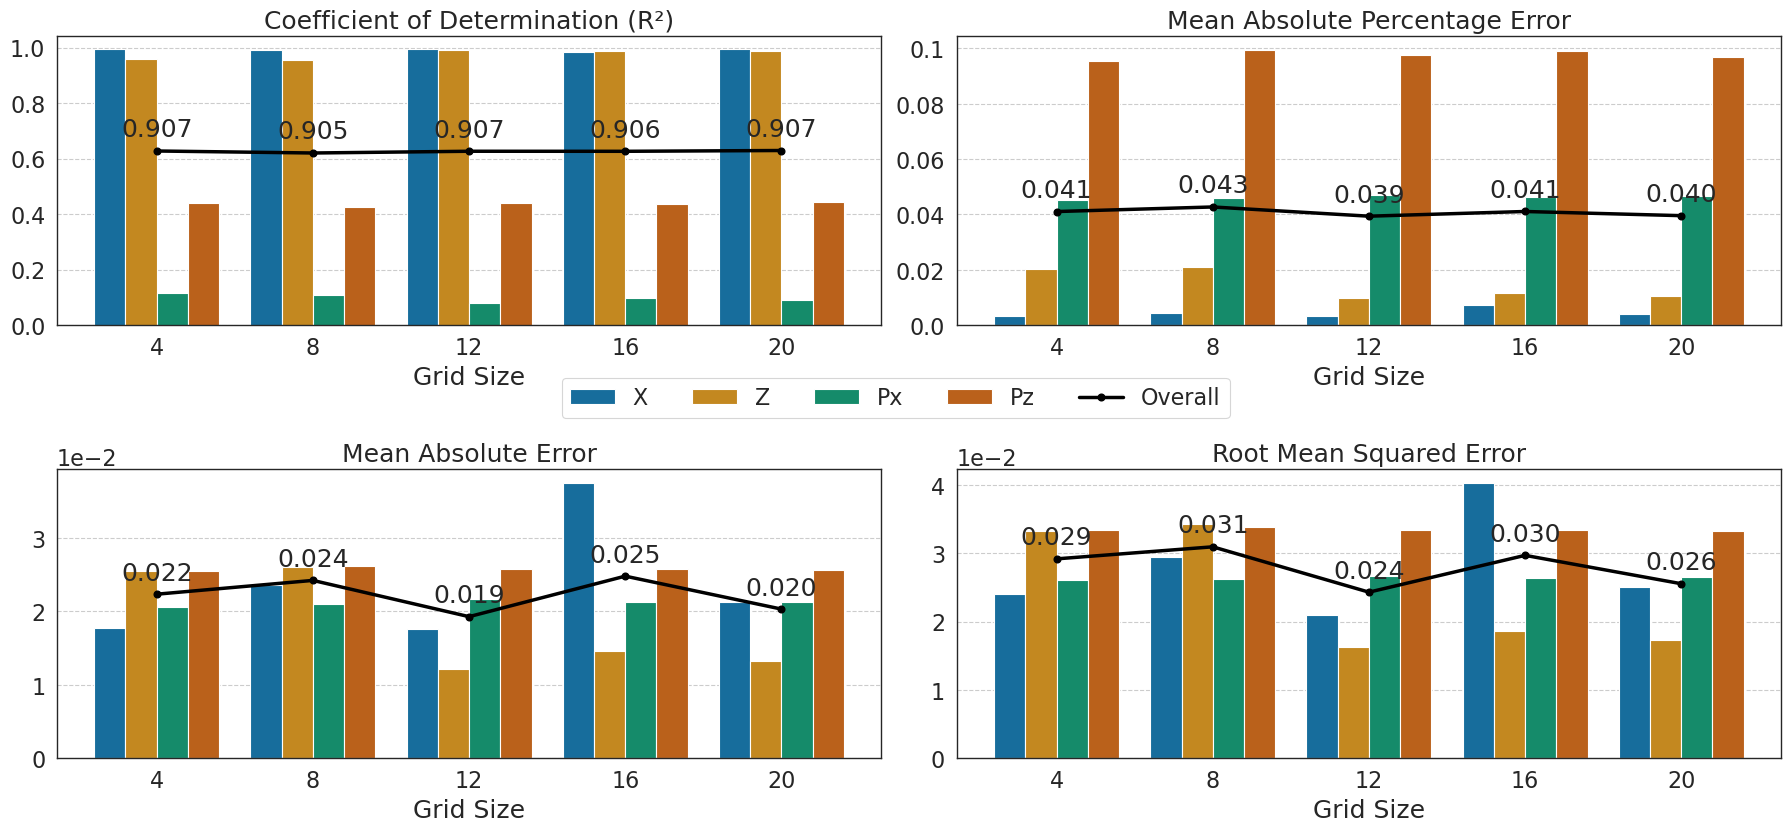

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")
sns.set_context("paper")

metric_title_map = {
    "MAE": "Mean Absolute Error",
    "RMSE": "Root Mean Squared Error",
    "MAPE": "Mean Absolute Percentage Error",
    "R²": "Coefficient of Determination (R²)",
}

# Skip MSE metric
filtered_metrics = ["R²", "MAPE", "MAE", "RMSE"]
targets = df_long['target'].unique()

# Color palette
palette = sns.color_palette("colorblind", n_colors=len(targets))
color_map = dict(zip(targets, palette))
color_map['Overall'] = 'black'

fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharey=False)

for metric, ax in zip(filtered_metrics, axes.flatten()):
    data = df_long[df_long['metric'] == metric]

    # Plot bars (excluding Overall)
    bar_data = data[data['target'] != 'Overall']
    sns.barplot(
        data=bar_data,
        x='grid_size',
        y='value',
        hue='target',
        palette=color_map,
        ax=ax,
        dodge=True
    )

    # Prepare Overall line (centered)
    overall_data = data[data['target'] == 'Overall'].sort_values('grid_size')
    x_vals = overall_data['grid_size'].unique()
    y_vals = overall_data['value'].values
    
    # Add horizontal grid lines
    ax.grid(axis='y', linestyle='--', alpha=1)

    # Convert categorical x-axis positions to numerical centers
    x_ticks = sorted(data['grid_size'].unique())
    x_pos = [x_ticks.index(x) for x in x_vals]

    ax.plot(
        x_pos,
        y_vals,
        color='black',
        marker='o',
        linewidth=2.5,
        label='Overall',
        zorder=5
    )

    ax.set_title(metric_title_map[metric], fontsize=18)
    ax.set_xlabel("Grid Size", fontsize=18)
    ax.set_ylabel(None)
    ax.set_xticks(range(len(x_ticks)))
    ax.set_xticklabels(x_ticks, fontsize=16)
    
    y_ticks = ax.get_yticks()
    if metric == 'R²':
        y_ticks = ax.get_yticks()
        y_ticks = [round(tick, 3) for tick in ax.get_yticks()]
        ax.set_yticklabels(y_ticks, fontsize=16)
    elif metric in ['MAE', 'RMSE']:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        y_ticks = ax.get_yticks()
        ax.tick_params(axis='y', labelsize=16)            # <-- bars & ticks
        ax.yaxis.get_offset_text().set_fontsize(16)       # <-- the “×10⁻³” offset text
    else:
        ax.set_yticklabels(y_ticks, fontsize=16)

    ax.legend_.remove()
    
    if metric == 'R²':
        ax.set_ylim(0.75, 1.01)
    
    for x, y in zip(x_pos, overall_data['value']):
        y_min, y_max = ax.get_ylim()
        ax.text(x, y + (0.05 * (y_max - y_min)), f"{y:.3f}", ha='center', fontsize=18)

# Custom legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles=handles,
    loc="upper center",
    ncol=len(targets),
    bbox_to_anchor=(0.5, 0.47),
    fontsize=16,
)

# Title and layout
plt.tight_layout()
plt.subplots_adjust(top=0.80, hspace=0.5)
plt.show()


In [ ]:
for metric, ax in zip(filtered_metrics, axes.flatten()):
    data = df_long[df_long['metric'] == metric]

    # Plot bars (excluding Overall)
    bar_data = data[data['target'] != 'Overall']
    sns.barplot(
        data=bar_data,
        x='factor',
        y='value',
        hue='target',
        palette=color_map,
        ax=ax,
        dodge=True
    )

    # Prepare Overall line (centered)
    overall_data = data[data['target'] == 'Overall'].sort_values('factor')
    x_vals = overall_data['factor'].unique()
    y_vals = overall_data['value'].values
    
    ax.grid(axis='y', linestyle='--', alpha=1)

    # Convert categorical x-axis positions to numerical centers
    x_ticks = sorted(data['factor'].unique())
    x_pos = [x_ticks.index(x) for x in x_vals]
    

    ax.plot(
        x_pos,
        y_vals,
        color='black',
        marker='o',
        linewidth=3,
        label='Overall',
        zorder=5
    )

    ax.set_title(metric_title_map[metric], fontsize=18)
    ax.set_xlabel("Factor", fontsize=18)
    ax.set_ylabel(None)
    ax.set_xticks(range(len(x_ticks)))
    ax.set_xticklabels(x_ticks, fontsize=16)
    
    y_ticks = ax.get_yticks()
    if metric == 'R²':
        y_ticks = ax.get_yticks()
        y_ticks = [round(tick, 3) for tick in ax.get_yticks()]
        ax.set_yticklabels(y_ticks, fontsize=16)
    elif metric in ['MAE', 'RMSE']:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        y_ticks = ax.get_yticks()
        ax.tick_params(axis='y', labelsize=16)            # <-- bars & ticks
        ax.yaxis.get_offset_text().set_fontsize(16)       # <-- the “×10⁻³” offset text
    else:
        ax.set_yticklabels(y_ticks, fontsize=16)

    ax.legend_.remove()
    
    if metric == 'R²':
        ax.set_ylim(0.75, 1.01)
    
    for x, y in zip(x_pos, overall_data['value']):
        y_min, y_max = ax.get_ylim()
        ax.text(x, y + (0.05 * (y_max - y_min)), f"{y:.3f}", ha='center', fontsize=18)

# Custom legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles=handles,
    loc="upper center",
    ncol=len(targets),
    bbox_to_anchor=(0.5, 0.47),
    fontsize=16,
)

# Title and layout
plt.tight_layout()
plt.subplots_adjust(top=0.80, hspace=0.5)
plt.show()